In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from hydra import initialize, compose

import time

import torch
from torch import optim

from bliss.models import encoder, decoder
from bliss.datasets import simulated

import sys
sys.path.insert(0, './utils/')
from which_device import device
import plotting_utils 
import flux_encoder_lib



# Load dataset

In [ ]:
overrides = {'model':"sleep_sdss_measure_simple", 'dataset':'default'}
overrides = [f"{key}={value}" for key, value in overrides.items()]
with initialize(config_path="../../config"): # possibly change relative path to config folder here. 
    cfg = compose("config", overrides=overrides)

In [ ]:
cfg.dataset.kwargs.generate_device = device

In [4]:
dataset = simulated.SimulatedDataset(**cfg.dataset.kwargs)


# save some constants we will use later
slen = dataset.image_decoder.slen
n_bands = dataset.image_decoder.n_bands

tile_slen = dataset.image_decoder.tile_slen
ptile_slen = dataset.image_decoder.ptile_slen

batch_size = dataset.batch_size
border_padding = dataset.image_decoder.border_padding
max_sources = dataset.image_decoder.max_sources

### Some sample images

In [5]:
train_dataloader = dataset.train_dataloader()

In [6]:
for _, batch in enumerate(train_dataloader):
    break

In [7]:
_true_tile_dict = dict(locs = batch['locs'],
                       n_sources = batch['n_sources'],
                       galaxy_bool = batch['galaxy_bool'])
    
true_params = encoder.get_full_params(_true_tile_dict, dataset.image_decoder.slen)

In [8]:
def plot_params(params, indx, ax): 
    locs = params['locs'][indx].cpu() * slen + border_padding
    locs = locs[:, (1, 0)]

    n_sources = int(params['n_sources'][indx])
    galaxy_bool = params['galaxy_bool'][indx].squeeze().cpu()    
    
    plotting_utils.plot_locations(locs, 
                                  galaxy_bool, 
                                  n = n_sources, 
                                  ax = ax)

In [9]:
%matplotlib inline

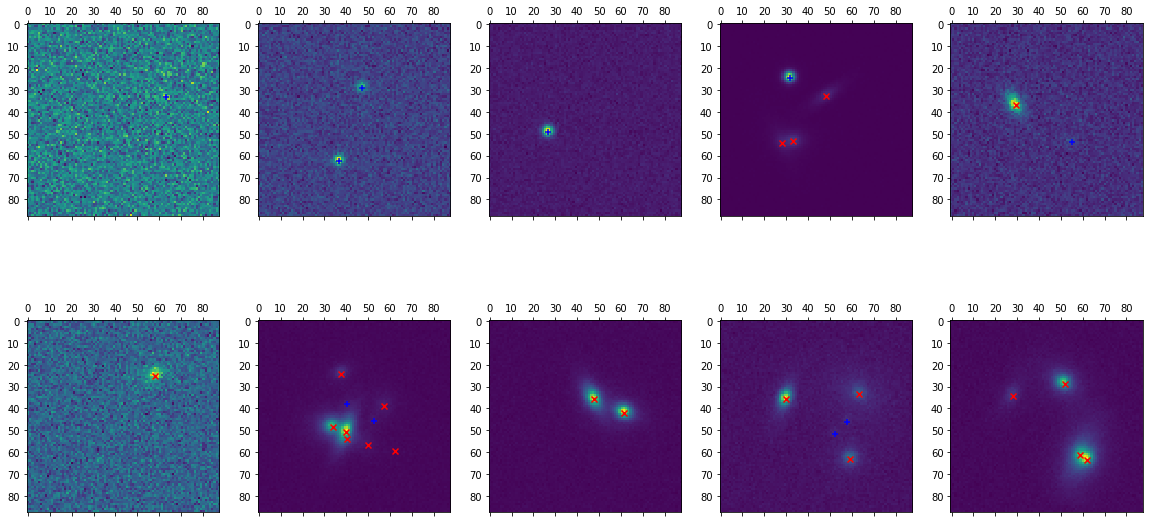

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(20,10))

for indx in range(10): 
    
    i0 = indx // 5
    i1 = indx % 5
    axes[i0, i1].matshow(batch['images'][indx, 0].cpu())

    plot_params(true_params, indx, axes[i0, i1])

In [11]:
flux_encoder = flux_encoder_lib.MLPEncoder(ptile_slen = ptile_slen, 
                                           tile_slen = tile_slen,
                                           n_bands = n_bands,
                                           max_sources = max_sources).to(device)

In [13]:
flux_estimates = flux_encoder(batch['images'])

In [15]:
flux_estimates['samples'].shape

torch.Size([32, 100, 1])

In [1]:
from einops import rearrange, repeat
import torch.nn.functional as F

In [2]:
def get_images_in_tiles(images, tile_slen, ptile_slen):
    
    # images should be batchsize x n_bands x slen x slen
    assert len(images.shape) == 4
    
    n_bands = images.shape[1]
    
    window = ptile_slen
    tiles = F.unfold(images, kernel_size=window, stride=tile_slen)
    
    # b: batch, c: channel, h: tile height, w: tile width, n: num of total tiles for each batch
    tiles = rearrange(tiles, "b (c h w) n -> (b n) c h w", c=n_bands, h=window, w=window)
    
    return tiles


In [3]:
get_images_in_tiles(batch['images'], tile_slen, ptile_slen).shape

NameError: name 'batch' is not defined

In [ ]:
foo = dict(a = 1, b = 2, c = 3)

In [ ]:
for k in foo.keys(): 
    print(foo[k])

In [ ]:
batch